In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
diseaseMapping = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', typ='series')

In [3]:
diseaseMapping

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

In [4]:
# train = pd.concat([train.image_id, pd.get_dummies(train.label)], axis=1)

In [5]:
train.image_id = "../input/cassava-leaf-disease-classification/train_images/" + train.image_id

In [6]:
train.shape

(21397, 2)

In [7]:
train.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,1
3,../input/cassava-leaf-disease-classification/t...,1
4,../input/cassava-leaf-disease-classification/t...,3


In [8]:
outliers = ['1021758544.jpg','1057462029.jpg','1430955699.jpg', '269713568.jpg','501215014.jpg','490603548.jpg',
     '501215014.jpg','413912363.jpg','314640668.jpg','421035788.jpg','723564013.jpg','891874541.jpg',
     '1014492188.jpg','1339403533.jpg','2229847111.jpg','2345003518.jpg','2489013604.jpg',
     '2605464541.jpg','2629773376.jpg','3379826408.jpg','1917903934.jpg','1981678917.jpg',
     '2098671662.jpg','2099754293.jpg','314640668.jpg', '421035788.jpg','413912363.jpg','501215014.jpg',
     '490603548.jpg','4214804223.jpg', '4134583704.jpg', '597389720.jpg','1179237425.jpg','1703248268.jpg',
     '1973109559.jpg','3086663390.jpg','3421208425.jpg','65139094.jpg','214745223.jpg','277532565.jpg',
     '357924077.jpg','544532198.jpg','725034194.jpg','1277049682.jpg','1963744346.jpg','2669409913.jpg',
     '2801552324.jpg','3442406076.jpg','3513851865.jpg','3523980600.jpg','3550082135.jpg',
     '3731977760.jpg','3844650986.jpg','4252095621.jpg','4280523848.jpg','249686764.jpg','420749600.jpg',
     '384390206.jpg','744383303.jpg','1096438409.jpg','1119403430.jpg','1190399034.jpg','1709404074.jpg',
     '3350363363.jpg','3571405769.jpg','3746679490.jpg','3724956866.jpg','4044550421.jpg',
     '4072965036.jpg','4177958446.jpg','4280091186.jpg']

In [9]:
outliers = [train[train.image_id == x].index for x in outliers]
outliers = [x.values[0] for x in outliers]
train.drop(outliers, axis=0, inplace=True)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
Train_Data = ImageDataGenerator(rescale=1/255.,
                                validation_split=0.2,
#                                 rotation_range=90,
#                                 width_shift_range=0.2,
#                                 height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                             )

In [11]:
image_shape = (460, 460)
step_size = 17066  // 32
val_step = 4266  // 32
NUM_CLASSES = 5

In [12]:
train.label = train.label.astype('str')

In [13]:
train_set = Train_Data.flow_from_dataframe(
        dataframe = train,
        x_col="image_id",
        y_col="label",
        shuffle=True,
        batch_size=32,
        subset="training",
        target_size=image_shape,
        class_mode="categorical"
    )

Found 17118 validated image filenames belonging to 5 classes.


In [14]:
validation_set = Train_Data.flow_from_dataframe(
        dataframe = train,
        x_col="image_id",
        y_col="label",
        shuffle=True,
        batch_size=32,
        subset="validation",
        target_size =image_shape,
        class_mode="categorical"
    )

Found 4279 validated image filenames belonging to 5 classes.


In [15]:
# plt.imshow(train_set.next()[0][0])

In [16]:
# current_balance = train['label'].value_counts(normalize=True)
# class_weight = {0: (1 - current_balance['0']) / (1 - current_balance.min()),
#                 1: (1 - current_balance['1']) / (1 - current_balance.min()),
#                 2: (1 - current_balance['2']) / (1 - current_balance.min()),
#                 3: (1 - current_balance['3']) / (1 - current_balance.min()),
#                 4: (1 - current_balance['4']) / (1 - current_balance.min())}

# class_weight

In [17]:
class_weight = {3: 0.4056622353520434,
4: 0.9266371245691778,
2: 0.9360413589364845,
1: 0.9457410142786805,
0: 1.0}

In [18]:
# model = tf.keras.Sequential([
#     ## Batch 1
# #     tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape = (224, 224, 3), padding='same'),
# #     tf.keras.layers.MaxPooling2D(4, 4),
# #     tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
    
# #     ## Batch 2
# #     tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
    
# #     ## Batch 3
# #     tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
    
# #     ## Batch 4
# #     tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
    
# # #     ## Batch 5
# #     tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
# #     tf.keras.layers.MaxPooling2D(2, 2),
    
    
#     tf.keras.layers.InputLayer(input_shape = (224, 224, 3)),
    
#     ## Batch 6
#     tf.keras.layers.Flatten(),    
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
    
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')     
# ])


# model.compile(loss = 'categorical_crossentropy', optimizer='adam', 
#               metrics=['accuracy'])

In [19]:
# history = model.fit(train_set, validation_data=validation_set, epochs=8,
#                     steps_per_epoch=step_size, validation_steps=val_step)

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(460,460,3),
                                               include_top=False,
                                               weights=None,
                                                pooling='avg'
                                              ) 
# base_model.trainable = False

add_model = Sequential() 
add_model.add(base_model)

add_model.add(Dense(1024, activation='relu'))
add_model.add(Dropout(0.5))

add_model.add(Dense(NUM_CLASSES, activation='softmax')) 

model = add_model 

In [21]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_460 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 3,574,853
Trainable params: 3,540,741
Non-trainable params: 34,112
_________________________________________________________________


In [22]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']) 

In [23]:
history = model.fit(
    train_set, validation_data=validation_set, epochs=30,
    steps_per_epoch=step_size, validation_steps=val_step,
    class_weight=class_weight,
                   
                   ) 

Epoch 1/30
533/533 [==============================] - 513s 962ms/step - loss: 0.8480 - accuracy: 0.5874 - val_loss: 1.3375 - val_accuracy: 0.6163
Epoch 2/30
533/533 [==============================] - 442s 829ms/step - loss: 0.7328 - accuracy: 0.6254 - val_loss: 1.5981 - val_accuracy: 0.1151
Epoch 3/30
533/533 [==============================] - 439s 824ms/step - loss: 0.6934 - accuracy: 0.6533 - val_loss: 2.2826 - val_accuracy: 0.1156
Epoch 4/30
533/533 [==============================] - 443s 831ms/step - loss: 0.6593 - accuracy: 0.6723 - val_loss: 2.3691 - val_accuracy: 0.1158
Epoch 5/30
533/533 [==============================] - 439s 823ms/step - loss: 0.6341 - accuracy: 0.6871 - val_loss: 2.9320 - val_accuracy: 0.1156
Epoch 6/30
533/533 [==============================] - 448s 840ms/step - loss: 0.6035 - accuracy: 0.7102 - val_loss: 2.1511 - val_accuracy: 0.1194
Epoch 7/30
533/533 [==============================] - 449s 842ms/step - loss: 0.5639 - accuracy: 0.7370 - val_loss: 2.6978 -

In [24]:
# copy = model

In [25]:
# history = model.fit(
#     train_set, validation_data=validation_set, epochs=10,
#     steps_per_epoch=step_size, validation_steps=val_step,
#     class_weight=class_weight,
                   
#                    ) 

In [26]:
# history = model.fit(
#     train_set, validation_data=validation_set, epochs=10,
#     steps_per_epoch=step_size, validation_steps=val_step,
#     class_weight=class_weight,
                   
#                    ) 

In [27]:
# !pip install -q efficientnet

In [28]:
# import efficientnet.tfkeras as efn

In [29]:
# model=tf.keras.Sequential([efn.EfficientNetB0(input_shape=(160, 160, 3),
#                                              weights="imagenet",
#                                              include_top=False),
#                            tf.keras.layers.Flatten(),
#                            tf.keras.layers.Dense(1024, activation="relu"),
#                            tf.keras.layers.Dropout(0.3),
#                            tf.keras.layers.Dense(NUM_CLASSES,activation="softmax")
                                             
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#               loss="categorical_crossentropy", metrics=["acc"])

In [30]:
# history = model.fit(train_set, validation_data=validation_set, epochs=10,
#                     steps_per_epoch=step_size, validation_steps=val_step) 

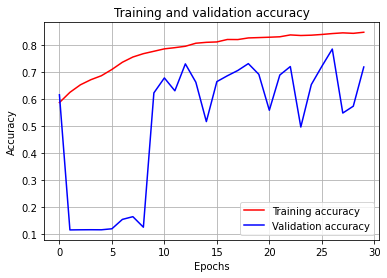

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.grid(axis='both')

plt.show() 

In [32]:
sample = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
# sample.head()

In [33]:
# img = Image.open('../input/cassava-leaf-disease-classification/train_images/1001320321.jpg')
# img = img.resize(image_shape)
# img = np.expand_dims(img,axis=0)
# y_pred = model.predict(img)

In [34]:
# model.evaluate(train_set) 

In [35]:
tf.keras.models.save_model(model, './Model') 

In [36]:
train.to_csv('./sub.csv')

In [37]:
# pretrained_model = tf.keras.applications.Xception(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=(224,224,3)
#     )
# pretrained_model.trainable = False

# model = tf.keras.Sequential([
#     pretrained_model, 
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
#     ])

In [38]:
# model.compile(loss='categorical_crossentropy', 
#               optimizer="adam",#lr=1e-4, momentum=0.9),
#               metrics=['accuracy'])

# history = model.fit(train_set, validation_data=validation_set, epochs=3,
#                     steps_per_epoch=step_size, validation_steps=val_step)


In [39]:
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras import applications
# from tensorflow.keras import optimizers

In [40]:
# base_model = applications.InceptionV3(weights='imagenet', 
#                                 include_top=False, 
#                                 input_shape=(150, 150,3))
# base_model.trainable = False

# add_model = Sequential()
# add_model.add(base_model)
# add_model.add(GlobalAveragePooling2D())
# add_model.add(Dropout(0.5))
# add_model.add(Dense(NUM_CLASSES, 
#                     activation='softmax'))

# model = add_model

In [41]:
# model.compile(loss='categorical_crossentropy', 
#               optimizer=optimizers.Adam(),#lr=1e-4, momentum=0.9),
#               metrics=['accuracy'])

In [42]:
# # story = model.fit(train_set, 
# #                               epochs=2, 
# # #                               shuffle=True, 
# # #                               verbose=True,
# # #                               callbacks=callbacks_list
# #                  )

# history = model.fit(train_set, validation_data=validation_set, epochs=10,
#                     steps_per_epoch=step_size, validation_steps=val_step)